In [1]:
import os
from PIL import Image
import IPython.display as display

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tqdm import tqdm

In [2]:
tf.keras.utils.get_file('/content/YellowLabradorLooking_new.jpg', 
                        'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
tf.keras.utils.get_file('/content/kandinsky5.jpg',
                        'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
tf.keras.utils.get_file('/content/GreenSeaTurtleGrazingSeagrass.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg')
tf.keras.utils.get_file('/content/TheGreatWaveOffKanagawa.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg')
tf.keras.utils.get_file('/content/VassilyKandinskyComposition.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
tf.keras.utils.get_file('/content/TuebingenNeckarfront.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg')
tf.keras.utils.get_file('/content/PillarsOfCreatio.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')
tf.keras.utils.get_file('/content/VanGoghStarryNight.jpg',
                        'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')


409600/396423 [==============================] - 0s 1us/step


'/content/VanGoghStarryNight.jpg'

In [3]:
CONTENT_PATH = './GreenSeaTurtleGrazingSeagrass.jpg'
STYLE_PATH = './TheGreatWaveOffKanagawa.jpg'

MAX_DIM = 512

In [4]:
def imshow(img, title=None):
    # out = out.astype('uint8')
    if title is not None:
        plt.title(title)
    plt.imshow(img)

In [5]:
def load_img(img_path):
    img = Image.open(img_path)
    scale = MAX_DIM/max(img.size)
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.constant(img, dtype=tf.float32) / 255.
    return img

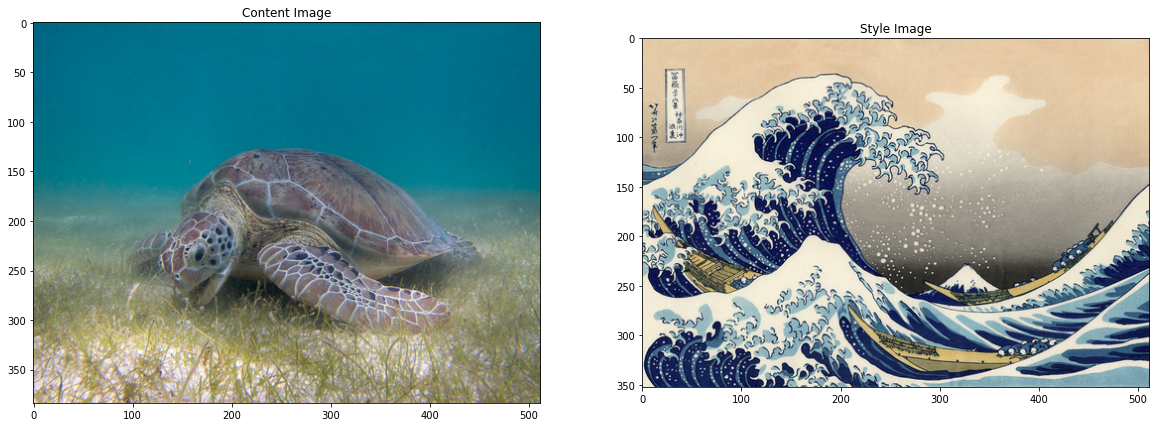

In [6]:
plt.figure(figsize=(20,20))

content = load_img(CONTENT_PATH)
style = load_img(STYLE_PATH)

plt.subplot(1, 2, 1)
imshow(content[0], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style[0], 'Style Image')

plt.show()

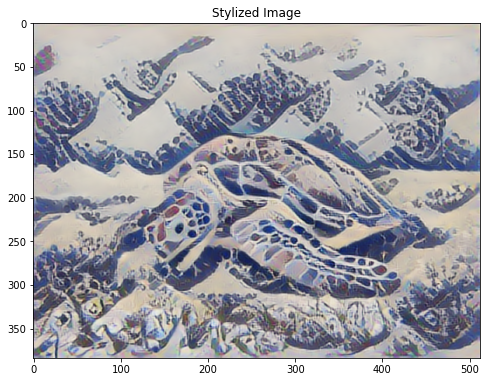

In [7]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(content, style)[0][0]

plt.figure(figsize=(8,8))
imshow(stylized_image, 'Stylized Image')

In [8]:
def process_img(img_array):
    img = img_array * 255
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

## VGG Features Classifier

In [9]:
content = load_img(CONTENT_PATH)
content = process_img(content)
content = tf.image.resize(content, (224, 224))

style = load_img(STYLE_PATH)
style = process_img(style)
style = tf.image.resize(style, (224, 224))

vgg_model = tf.keras.applications.VGG19(weights="imagenet", include_top=True)

574726144/574710816 [==============================] - 4s 0us/step


In [10]:
probs_content = vgg_model(content)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(probs_content.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('loggerhead', 0.7737118),
 ('leatherback_turtle', 0.10222404),
 ('hermit_crab', 0.054887176),
 ('terrapin', 0.026351783),
 ('conch', 0.01197946)]

## VGG Model

In [11]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

vgg_model.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def create_vgg_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]

    model_outputs = style_outputs + content_outputs

    return tf.keras.Model(vgg.input, model_outputs)

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Content and Style Loss

In [15]:
loss_fn = tf.keras.losses.MeanSquaredError()

In [16]:
def get_total_loss(style_output, style_target, content_output, content_target):
    style_weight=1e-2
    content_weight=1e4

    style_loss = tf.add_n([loss_fn(content_output[i], content_target[i]) 
                            for i in range(num_content_layers)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([loss_fn(style_output[i], style_target[i])
                             for i in range(num_style_layers)])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    
    return loss

## Training

In [30]:
content = load_img(CONTENT_PATH)
style = load_img(STYLE_PATH)

In [31]:
def get_features(model, image_array):
    proccessed_img = process_img(image_array)
    outputs = model(proccessed_img)
    style_outputs, content_outputs = (outputs[:num_style_layers],
                                        outputs[num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

    return style_outputs, content_outputs

In [32]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [33]:
vgg = create_vgg_model()

In [34]:
style_target = get_features(vgg, style)[0]
content_target = get_features(vgg, content)[1]

In [35]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [36]:
image = tf.Variable(content)

In [37]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        style_output, content_output = get_features(vgg, image)
        loss = get_total_loss(style_output, style_target, content_output, content_target)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [38]:
def tensor_to_array(tensor):
    tensor = tensor * 255
    np_array = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        np_array = np_array[0]
    return np_array

100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


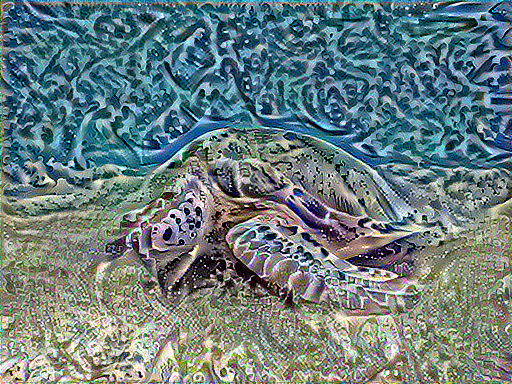

Train step: 100


100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


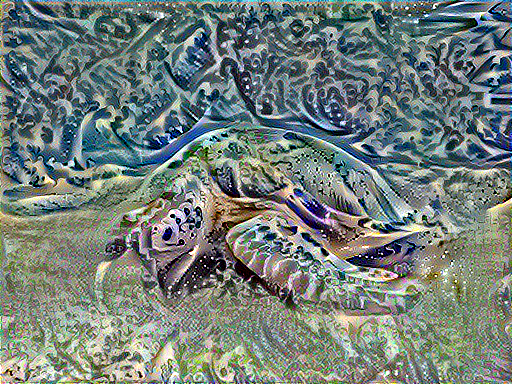

Train step: 200


100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


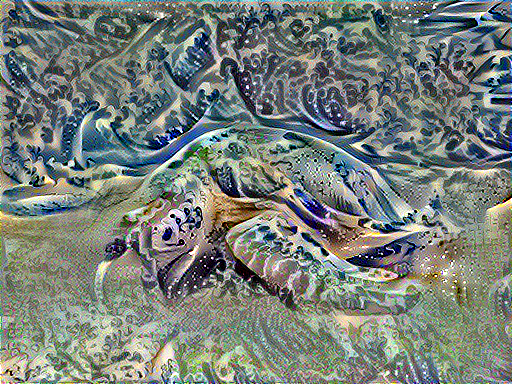

Train step: 300


100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


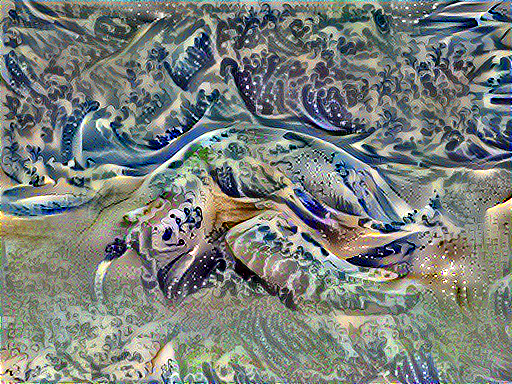

Train step: 400


100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


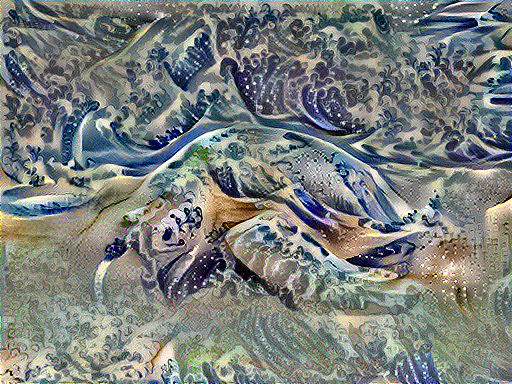

Train step: 500


100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


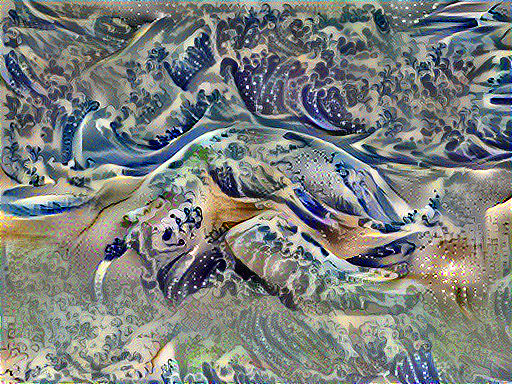

Train step: 600


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


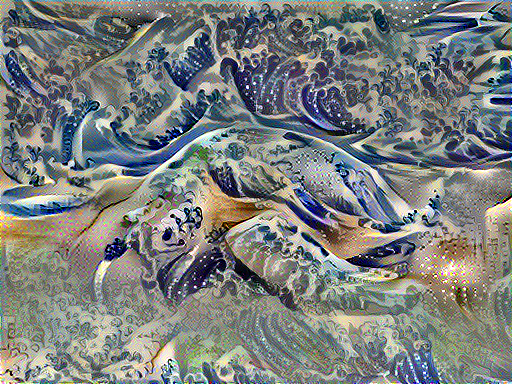

Train step: 700


100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


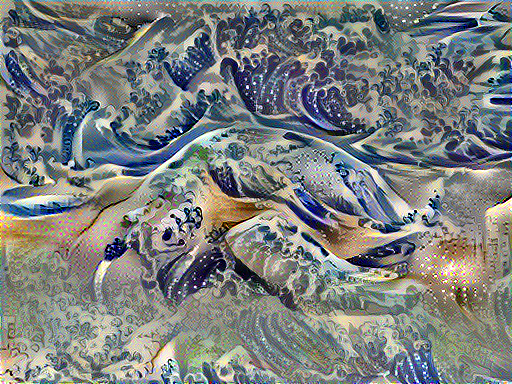

Train step: 800


100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


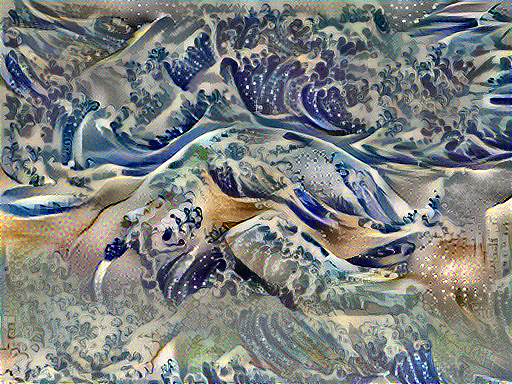

Train step: 900


100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


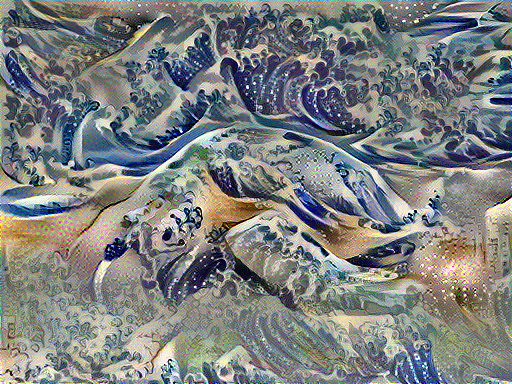

Train step: 1000


In [39]:
epochs = 10
steps_per_epoch = 100

images_arr = []

step = 0
for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
        step += 1
        train_step(image)
        img = Image.fromarray(tensor_to_array(image))
        images_arr.append(img)

    display.display(img)
    print("Train step: {}".format(step))

In [62]:
images_arr[0].save("turtle.gif", save_all=True, append_images=images_arr[1::20], duration=100, loop=0)

In [69]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif('turtle.gif')

## Other Demonstarations

In [70]:
CONTENT_PATH = '/content/YellowLabradorLooking_new.jpg'
STYLE_PATH = '/content/kandinsky5.jpg'
content = load_img(CONTENT_PATH)
style = load_img(STYLE_PATH)

In [71]:
style_target = get_features(vgg, style)[0]
content_target = get_features(vgg, content)[1]

In [72]:
image = tf.Variable(content)

In [73]:
epochs = 10
steps_per_epoch = 100

images_arr = []

step = 0
for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
        step += 1
        train_step(image)
        img = Image.fromarray(tensor_to_array(image))
        images_arr.append(img)

    display.display(img)
    print("Train step: {}".format(step))